In [343]:
import cv2
from glob import glob
import numpy as np
from matplotlib import pyplot as plt

In [344]:
sift = cv2.SIFT_create()
bilder = glob("../bildverband2/*.JPG")[:2]
data = []
for pfad in bilder:
        image1 = cv2.imread(pfad)
        print(pfad)
        gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
        kp, desc = sift.detectAndCompute(gray_image1, None)
        data.append({"id": id, "kp": kp, "desc": desc, "img": image1})

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=100)
flann = cv2.FlannBasedMatcher(index_params, search_params)


../bildverband2/DJI_0285.JPG
../bildverband2/DJI_0286.JPG
../bildverband2/DJI_0287.JPG
../bildverband2/DJI_0288.JPG
../bildverband2/DJI_0289.JPG


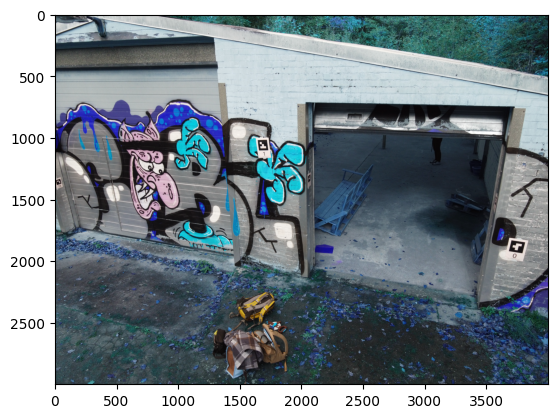

In [345]:
plt.imshow(data[0]["img"])


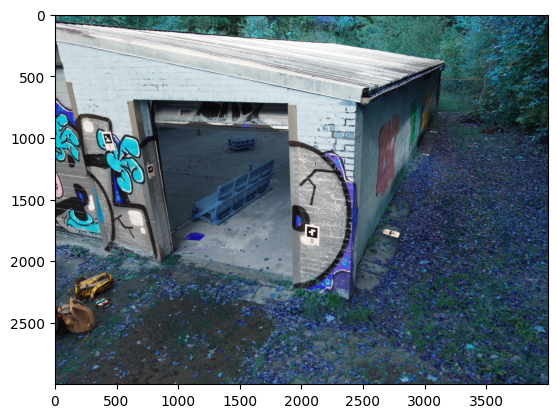

In [346]:
plt.imshow(data[1]["img"])


In [347]:
matches = flann.knnMatch(data[0]["desc"], data[1]["desc"], k=2)


In [348]:
pts1 = []
pts2 = []


for i, (m, n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(data[1]["kp"][m.trainIdx].pt)
        pts1.append(data[0]["kp"][m.queryIdx].pt)

pts1 = np.array(pts1)
pts2 = np.array(pts2)


In [349]:
len(pts1)

3505

In [350]:
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_8POINT)
F

array([[ 1.75007459e-08,  5.10468642e-07, -7.49170934e-04],
       [-1.38597395e-07,  1.78327319e-07,  1.25040691e-03],
       [ 1.33132666e-04, -2.15539021e-03,  1.00000000e+00]])

In [400]:
K = np.array([[3000,0,2000],
            [0,3000,1500],
            [0,0,1]])

In [401]:
E, mask = cv2.findEssentialMat(pts1,pts2,K)
E

array([[ 5.45867908e-05,  1.28756772e-01,  3.50800879e-02],
       [-1.07694216e-01, -3.30623556e-03, -6.97928120e-01],
       [-2.97670737e-02,  6.94668421e-01, -5.30549700e-03]])

In [402]:
retval, R, t, mask = cv2.recoverPose(E, pts1, pts2, K)
R,t

(array([[ 0.99951362, -0.00859144,  0.02997842],
        [ 0.00877783,  0.99994292, -0.00609141],
        [-0.02992438,  0.0063516 ,  0.99953198]]),
 array([[-0.98202961],
        [-0.05074177],
        [ 0.18177766]]))

In [403]:
from etc import rotationMatrixToEulerAngles
rotationMatrixToEulerAngles(R)*180/np.pi

array([0.36408511, 1.71479653, 0.50316435])

In [404]:
mask.T@mask

array([[148]], dtype=uint8)

In [405]:
R_t_0 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])
R_t_1 = np.empty((3, 4))
P1 = np.matmul(K, R_t_0)
P2 = np.empty((3, 4))

R_t_1[:3, :3] = np.matmul(R, R_t_0[:3, :3])
R_t_1[:3, 3] = R_t_0[:3, 3] + np.matmul(R_t_0[:3, :3], t.ravel())

print("The R_t_0 \n" + str(R_t_0))
print("The R_t_1 \n" + str(R_t_1))

P2 = np.matmul(K, R_t_1)


The R_t_0 
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]]
The R_t_1 
[[ 0.99951362 -0.00859144  0.02997842 -0.98202961]
 [ 0.00877783  0.99994292 -0.00609141 -0.05074177]
 [-0.02992438  0.0063516   0.99953198  0.18177766]]


In [406]:
pts1[0]

array([   9.45431042, 1368.07312012])

In [407]:
points_3d = cv2.triangulatePoints(P1,P2,pts1.T,pts2.T)
points_3d /= points_3d[3]
points_3d


array([[ 1.87689340e+03, -1.45398597e+01, -2.85125114e+00, ...,
         4.09181921e-01, -2.86541766e+00, -1.93062155e+00],
       [-4.01917199e+02,  1.72721631e+00, -4.33046447e-01, ...,
        -1.74104118e+00, -7.11296124e+00, -4.64447036e-01],
       [-4.27623615e+03,  2.59469201e+01,  5.70907878e+00, ...,
        -5.57310869e+00, -5.84127426e+01,  4.04097980e+00],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00]])

In [408]:
K@points_3d[:3,0]


array([-2.92179211e+06, -7.62010583e+06, -4.27623615e+03])

In [409]:
p = points_3d[:3,0]
-3000*(p[0]/p[2])+2000

3316.7374279181836

In [410]:
R_t_0[:,3]

array([0, 0, 0])

In [411]:
rod,_ = cv2.Rodrigues(np.float64(R_t_0[:3, :3]))
rod

array([[0.],
       [0.],
       [0.]])

In [412]:
tvec = np.float64(R_t_0[:,3])
tvec

array([0., 0., 0.])

In [413]:
kmat = np.float64(K)
kmat

array([[3.0e+03, 0.0e+00, 2.0e+03],
       [0.0e+00, 3.0e+03, 1.5e+03],
       [0.0e+00, 0.0e+00, 1.0e+00]])

In [414]:
imgP, _ = cv2.projectPoints(points_3d[:3,:].T,rod,tvec, kmat, np.zeros(4))
imgP

array([[[ 683.26257208, 1781.96562414]],

       [[ 318.89183843, 1699.70188762]],

       [[ 501.72790636, 1272.44326283]],

       ...,

       [[1779.73769546, 2437.20109334]],

       [[2147.16400204, 1865.3121349 ]],

       [[ 566.71774062, 1155.19720975]]])

In [423]:
imgP.shape

(3505, 1, 2)